In [1]:
!pip install langgraph langchain litellm langchain-community geopy requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 2.9 MB/s eta 0:00:00


ReAct agent from scratch with Nebius AI Studio and LangGraph

LangGraph is a framework for building stateful LLM applications, making it a good choice for constructing ReAct (Reasoning and Acting) Agents.

ReAct agents combine LLM reasoning with action execution. They iteratively think, use tools, and act on observations to achieve user goals, dynamically adapting their approach.

While LangGraph offers a prebuilt ReAct agent (create_react_agent), it shines when you need more control and customization for your ReAct implementations.

LangGraph models agents as graphs using three key components:

State: Shared data structure (typically TypedDict or Pydantic BaseModel) representing the application's current snapshot.
Nodes: Encodes logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State, such as LLM calls or tool calls.
Edges: Define the next Node to execute based on the current State, allowing for conditional logic and fixed transitions.

Set your API key in the environment variable `NEBIUS_API_KEY`

In [3]:
import os

# Read your API key from the environment variable or set it manually
api_key = os.getenv("NEBIUS_API_KEY")

To better understand how to implement a ReAct agent using LangGraph, let's walk through a practical example. You will create a simple agent whose goal is to use a tool to find the current weather for a specified location.

For this weather agent, its State will need to maintain the ongoing conversation history (as a list of messages) and a counter for the number of steps taken to further illustrate state management.

LangGraph provides a convenient helper, add_messages, for updating message lists in the state. It functions as a reducer, meaning it takes the current list and new messages, then returns a combined list. It smartly handles updates by message ID and defaults to an "append-only" behavior for new, unique messages.

In [4]:
from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages # helper function to add messages to the state


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [5]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location:str = Field(description="The city and state, e.g., San Francisco")
    date:str = Field(description="the forecasting date for when to get the weather format (yyyy-mm-dd)")

@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}

tools = [get_weather_forecast]

Next, you initialize your model and bind the tools to the model.



In [6]:
from datetime import datetime
from langchain_community.chat_models import ChatLiteLLM


# Create LLM class
llm = ChatLiteLLM(model="nebius/Qwen/Qwen3-235B-A22B")


# Bind tools to the model
model = llm.bind_tools([get_weather_forecast])

# Test the model with tools
res=model.invoke(f"What is the weather in Berlin on {datetime.today()}?")

print(res)

<ipython-input-6-b22f41d41f7c>:6: LangChainDeprecationWarning: The class `ChatLiteLLM` was deprecated in LangChain 0.3.24 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-litellm package and should be used instead. To use it run `pip install -U :class:`~langchain-litellm` and import as `from :class:`~langchain_litellm import ChatLiteLLM``.
  llm = ChatLiteLLM(model="nebius/Qwen/Qwen3-235B-A22B")


content='<think>\nOkay, the user is asking for the weather in Berlin on June 9, 2025, at 17:44. Let me check the tools available. There\'s a function called get_weather_forecast that takes location and date parameters. The date needs to be in yyyy-mm-dd format. The user\'s query includes the date and time, but the function\'s date parameter only requires the date part, not the full timestamp. So I should extract just the date portion from the user\'s input. The location is Berlin. Wait, the example for location was San Francisco, but Berlin is a city too. The function should accept Berlin as the location. I\'ll need to call get_weather_forecast with location="Berlin" and date="2025-06-09". I don\'t need the time part from the user\'s query since the function\'s date parameter is a date only. That should work. Let me structure the JSON accordingly.\n</think>\n\n' additional_kwargs={'tool_calls': [ChatCompletionMessageToolCall(function=Function(arguments='{"location": "Berlin", "date": "

The last step before you can run your agent is to define your nodes and edges. In this example, you have two nodes and one edge. - call_tool node that executes your tool method. LangGraph has a prebuilt node for this called ToolNode. - call_model node that uses the model_with_tools to call the model. - should_continue edge that decides whether to call the tool or the model.

The number of nodes and edges is not fixed. You can add as many nodes and edges as you want to your graph. For example, you could add a node for adding structured output or a self-verification/reflection node to check the model output before calling the tool or the model.

In [7]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

Now you have all the components to build your agent. Let's put them together.



In [8]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)
# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

You can visualize your graph using the draw_mermaid_png method.



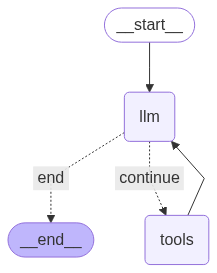

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from datetime import datetime
# Create our initial message dictionary
inputs = {"messages": [("user", f"What is the weather in Berlin on {datetime.today()}?")]}

# call our graph with streaming to see the steps
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

What is the weather in Berlin on 2025-06-09 17:44:41.953543?
================================== Ai Message ==================================

<think>
Okay, the user is asking for the weather in Berlin on June 9, 2025, at 17:44:41.953543. Let me check the tools available. There's a function called get_weather_forecast that takes location and date parameters. The date needs to be in yyyy-mm-dd format. The user provided the date as 2025-06-09, which is already in the correct format. The time part here is 17:44:41, but the function's description says it returns hourly temperature. So maybe the time in the query is not necessary for the function call because the function might aggregate by hour. Wait, the parameters require location and date, so I should extract Berlin and the date 2025-06-09. The timestamp after the date isn't needed since the function's date parameter is just the day. So I need to call get_

In [12]:
state["messages"].append(("user", "Would it be in reykjavik warmer?"))

for state in graph.stream(state, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

Would it be in reykjavik warmer?
================================== Ai Message ==================================

<think>
Okay, the user is asking if Reykjavik would be warmer on June 9, 2025, at the same time, 17:44:41. They previously asked about Berlin and Munich, so they're comparing temperatures across different cities.

First, I need to check the weather forecast for Reykjavik on that date. The function get_weather_forecast requires location (city) and date. The date is still 2025-06-09.

I should call the function with location as Reykjavik and date as 2025-06-09. Since the user is following up, they expect a similar response structure as before.

I need to make sure the tool call is correctly formatted. The function name is get_weather_forecast, arguments: location "Reykjavik" and date "2025-06-09".
</think>
Tool Calls:
  get_weather_forecast (chatcmpl-tool-d93f12e69b13449c8b3994dda78c4dd6)
 Call

================================= Tool Message =================================
Name: get_weather_forecast

{'2025-06-09T00:00': 7.1, '2025-06-09T01:00': 6.6, '2025-06-09T02:00': 6.3, '2025-06-09T03:00': 5.9, '2025-06-09T04:00': 5.5, '2025-06-09T05:00': 5.6, '2025-06-09T06:00': 5.9, '2025-06-09T07:00': 6.4, '2025-06-09T08:00': 7.1, '2025-06-09T09:00': 8.1, '2025-06-09T10:00': 8.7, '2025-06-09T11:00': 9.4, '2025-06-09T12:00': 9.8, '2025-06-09T13:00': 10.4, '2025-06-09T14:00': 10.2, '2025-06-09T15:00': 10.4, '2025-06-09T16:00': 10.5, '2025-06-09T17:00': 10.5, '2025-06-09T18:00': 10.1, '2025-06-09T19:00': 9.9, '2025-06-09T20:00': 9.6, '2025-06-09T21:00': 9.4, '2025-06-09T22:00': 9.1, '2025-06-09T23:00': 9.0}
================================== Ai Message ==================================

<think>
Okay, the user asked if Reykjavik would be warmer on June 9, 2025, at 17:44:41. From previous interactions, they compared Berlin and Munich, so they're likely checking temperatures in different 